## Before/after calibration NDVI time-series for some regions

In the areas with the worst correlation between MODIS and AVHRR, plot the timeseries before and after calibration to demonstrate the improvements

## Libraries

In [1]:
import xarray as xr
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import contextily as ctx

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

## Analysis Parameters

In [22]:
model_var='NDVI'
crs='epsg:4326'
name='trees'

# #Tassie
lat=slice(-39,-45) 
lon=slice(144,149)
plotname = 'Tasmania'

#queensland
# lat=slice(-10,-20) 
# lon=slice(140,150)
# plotname='Northern Queensland'

# #SW WA
# lat=slice(-31,-36) 
# lon=slice(114.5,119)
# plotname='Southwest WA'


## Open data

In [16]:
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

#open calibrated AVHRR
merge = assign_crs(xr.open_dataset(base+'NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_wGaps.nc'),
                   crs=crs)['NDVI']

#open original AVHRR
avhrr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_NDVI_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
avhrr = assign_crs(avhrr, crs=crs)

#Open MODIS
modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)

#clip time lengths
merge = merge.sel(time=slice('1982','2000-02'))
avhrr = avhrr.sel(time=slice('1982','2000-02'))

## Mask areas

In [17]:
# define no-data areas in calibrated
mask = ~np.isnan(merge)

#mask for the trees regions
trees = xr.open_dataset(base+'5km/WCF_5km_monthly_1982_2022.nc')['WCF']
trees = assign_crs(trees, crs ='epsg:4326')
trees = trees.sel(time=slice('2001', '2018'))
trees = trees.mean('time')

if name=='trees':
    mask1 = xr.where(trees>0.25, 1, 0)
if name=='nontrees':
    mask1 = xr.where(trees<=0.25, 1, 0)

mask = round_coords(mask)
mask1 = round_coords(mask1)

#do the masking
avhrr = avhrr.where(mask)
merge = merge.where(mask1)
avhrr = avhrr.where(mask1)
modis = modis.where(mask1)

## Create a plot

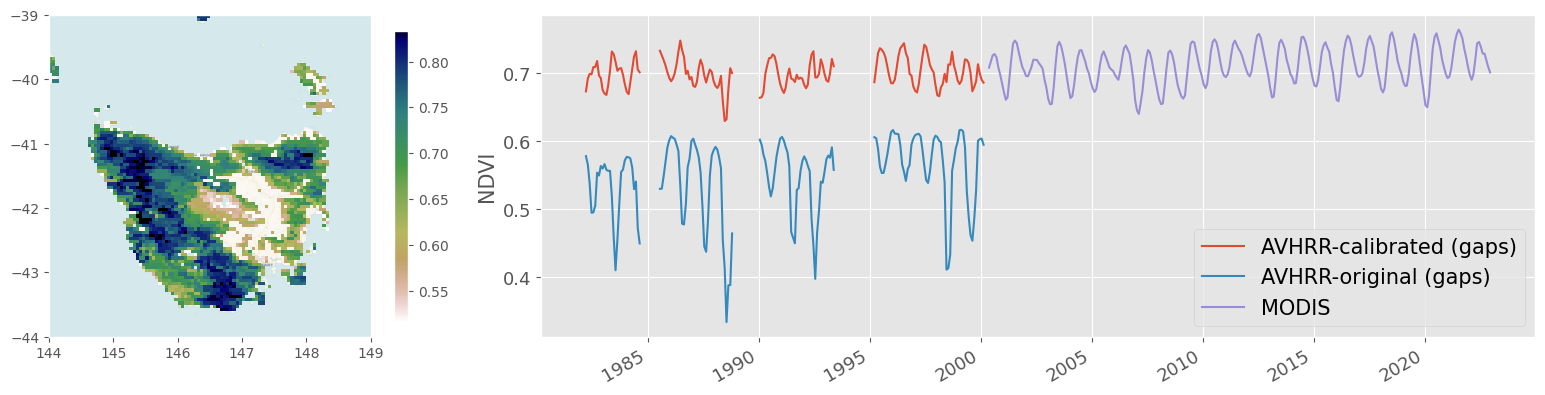

In [23]:
mosiac = [
    ["A", "B", "B"],
]

fig, ax = plt.subplot_mosaic(mosiac, figsize=(16,4))

im = modis.sel(longitude=lon, latitude=lat).mean('time').plot(robust=True, cmap='gist_earth_r',ax=ax['A'], add_colorbar=False, add_labels=False) 
cbar = plt.colorbar(im, ax=ax['A'], shrink=0.9)
# ax['A'].set_yticklabels([])
# ax['A'].set_xticklabels([])
ax['A'].set_ylabel('')
ax['A'].set_xlabel('')
ctx.add_basemap(ax['A'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)

ax["B"].grid(True)
merge.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=ax["B"], label='AVHRR-calibrated (gaps)')
avhrr.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=ax["B"], label='AVHRR-original (gaps)')
modis.sel(longitude=lon, latitude=lat).mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=ax["B"], label='MODIS')
ax["B"].legend(fontsize=15)
ax["B"].set_title(None)
ax["B"].set_ylabel('NDVI', fontsize=15)
ax["B"].set_xlabel(None)
# ax["B"].set_ylim(0.35,0.8)
ax['B'].tick_params(axis='y', labelsize=13)
ax['B'].tick_params(axis='x', labelsize=13)
plt.tight_layout();

fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/Tassie_trees_timeseries.png",
            bbox_inches='tight', dpi=300);